In [35]:
from data import CamVid as dataset
from data.utils import enet_weighing
from models.enet import ENet
from metric.iou import IoU
import utils
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision.transforms as transforms
import transforms as ext_transforms
from PIL import Image

In [32]:
# Display the example of model structure

model = ENet(12).to("cuda:0")
optimizer = optim.Adam(model.parameters())
# Load the previoulsy saved model state to the ENet model
model = utils.load_checkpoint(model, optimizer, 'save/eNet_camvid/', 'enet')[0]
print(model)

ENet(
  (initial_block): InitialBlock(
    (main_branch): Conv2d(3, 13, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (ext_branch): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (batch_norm): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (out_prelu): PReLU(num_parameters=1)
  )
  (downsample1_0): DownsamplingBottleneck(
    (main_max1): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (ext_conv1): Sequential(
      (0): Conv2d(16, 4, kernel_size=(2, 2), stride=(2, 2), bias=False)
      (1): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): PReLU(num_parameters=1)
    )
    (ext_conv2): Sequential(
      (0): Conv2d(4, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): PReLU(num_parameters=1)
    )
    (ext_conv3)

In [81]:
class Test:
    def __init__(self, model, data_loader, criterion, metric, device):
        self.model = model
        self.data_loader = data_loader
        self.criterion = criterion
        self.metric = metric
        self.device = device

    def run_epoch(self, iteration_loss=False):
        self.model.eval()
        epoch_loss = 0.0
        self.metric.reset()
        for step, batch_data in enumerate(self.data_loader):
            # Get the inputs and labels
            inputs = batch_data[0].to(self.device)
            labels = batch_data[1].to(self.device)

            with torch.no_grad():
                # Forward propagation
                outputs = self.model(inputs)

                # Loss computation
                loss = self.criterion(outputs, labels)

            # Keep track of loss for current epoch
            epoch_loss += loss.item()

            # Keep track of evaluation the metric
            self.metric.add(outputs.detach(), labels.detach())

            if iteration_loss:
                print("[Step: %d] Iteration loss: %.4f" % (step, loss.item()))

        return epoch_loss / len(self.data_loader), self.metric.value()
    
def test(model, test_loader, class_weights, class_encoding):
    print("\nTesting...\n")

    num_classes = len(class_encoding)
    criterion = nn.CrossEntropyLoss(weight=class_weights)

    ignore_index = list(class_encoding).index('unlabeled')

    metric = IoU(num_classes, ignore_index=ignore_index)

    # Test the trained model on the test set
    test = Test(model, test_loader, criterion, metric, device)
    print(">>>> Running test dataset")

    loss, (iou, miou) = test.run_epoch()
    class_iou = dict(zip(class_encoding.keys(), iou))
    print(">>>> Avg. loss: {0:.4f} | Mean IoU: {1:.4f}".format(loss, miou))

    # Print per class IoU
    for key, class_iou in zip(class_encoding.keys(), iou):
        print("{0}: {1:.4f}".format(key, class_iou))
    
    return miou, iou

In [86]:
def test_enet_camvid(save_dir, model_name_list):
    dataset_dir = 'dataset/camvid/'
    height = 360
    width = 480
    batch_size = 10
    num_classes = 12
    device = "cuda:0"
    
    image_transform = transforms.Compose(
        [transforms.Resize((height, width)),
         transforms.ToTensor()])

    label_transform = transforms.Compose([
        transforms.Resize((height, width), Image.NEAREST),
        ext_transforms.PILToLongTensor()
    ])
    # Load the test set as tensors
    test_set = dataset(
        dataset_dir,
        mode='test',
        transform=image_transform,
        label_transform=label_transform)
    test_loader = data.DataLoader(
        test_set,
        batch_size,
        shuffle=False,
        num_workers=12)

    train_set = dataset(
        dataset_dir,
        transform=image_transform,
        label_transform=label_transform)
    train_loader = data.DataLoader(
        train_set,
        batch_size=batch_size,
        shuffle=True,
        num_workers=12)

    # Get encoding between pixel valus in label images and RGB colors
    class_encoding = train_set.color_encoding
    if(len(class_encoding)==13):
        del class_encoding['road_marking']

    class_weights = enet_weighing(train_loader, num_classes)
    if class_weights is not None:
        class_weights = torch.from_numpy(class_weights).float().to(device)
    # Set the weight of the unlabeled class to 0
    ignore_index = list(class_encoding).index('unlabeled')
    class_weights[ignore_index] = 0
    
    miou_list = []
    iou_list = []

    for model_name in model_name_list:
        model = ENet(num_classes).to(device)
        optimizer = optim.Adam(model.parameters())

        # Load the previoulsy saved model state to the ENet model
        model = utils.load_checkpoint(model, optimizer, save_dir, model_name)[0]

        miou, iou = test(model, test_loader, class_weights, class_encoding)
        print('The model_name is: ',model_name)
        
        
        miou_list.append(miou)
        iou_list.append(iou)
    return miou_list, iou_list

In [88]:
model_name_list = []
for i in range(15):
    model_name_list.append('enet_'+str((i+1)*20))

miou_batch10_list, iou_batch10_list = test_enet_camvid('save/eNet_camvid_batch10_save/',model_name_list)


Testing...

>>>> Running test dataset
>>>> Avg. loss: 0.9124 | Mean IoU: 0.3843
sky: 0.9012
building: 0.6565
pole: 0.0033
road: 0.8871
pavement: 0.6812
tree: 0.5563
sign_symbol: 0.0000
fence: 0.0792
car: 0.4605
pedestrian: 0.0016
bicyclist: 0.0000
unlabeled: nan
The model_name is:  enet_20

Testing...

>>>> Running test dataset
>>>> Avg. loss: 0.9928 | Mean IoU: 0.4056
sky: 0.8941
building: 0.4535
pole: 0.1393
road: 0.9005
pavement: 0.7115
tree: 0.4699
sign_symbol: 0.0923
fence: 0.1422
car: 0.5367
pedestrian: 0.1202
bicyclist: 0.0011
unlabeled: nan
The model_name is:  enet_40

Testing...

>>>> Running test dataset
>>>> Avg. loss: 0.9488 | Mean IoU: 0.4750
sky: 0.9050
building: 0.5925
pole: 0.1750
road: 0.9114
pavement: 0.7264
tree: 0.5833
sign_symbol: 0.1400
fence: 0.1073
car: 0.6870
pedestrian: 0.1808
bicyclist: 0.2165
unlabeled: nan
The model_name is:  enet_60

Testing...

>>>> Running test dataset
>>>> Avg. loss: 0.9469 | Mean IoU: 0.4988
sky: 0.8733
building: 0.6420
pole: 0.1998
r

In [89]:
miou_batch5_list, iou_batch5_list = test_enet_camvid('save/eNet_camvid_batch5_save/',model_name_list)


Testing...

>>>> Running test dataset
>>>> Avg. loss: 0.9264 | Mean IoU: 0.3810
sky: 0.8404
building: 0.4164
pole: 0.0057
road: 0.8905
pavement: 0.6857
tree: 0.5251
sign_symbol: 0.0688
fence: 0.0938
car: 0.6147
pedestrian: 0.0496
bicyclist: 0.0000
unlabeled: nan
The model_name is:  enet_20

Testing...

>>>> Running test dataset
>>>> Avg. loss: 0.8668 | Mean IoU: 0.4589
sky: 0.8884
building: 0.5861
pole: 0.1445
road: 0.9057
pavement: 0.7226
tree: 0.6037
sign_symbol: 0.1281
fence: 0.1234
car: 0.6320
pedestrian: 0.1935
bicyclist: 0.1195
unlabeled: nan
The model_name is:  enet_40

Testing...

>>>> Running test dataset
>>>> Avg. loss: 0.9002 | Mean IoU: 0.4826
sky: 0.8777
building: 0.5396
pole: 0.1824
road: 0.9129
pavement: 0.7151
tree: 0.5708
sign_symbol: 0.1240
fence: 0.1643
car: 0.6651
pedestrian: 0.2322
bicyclist: 0.3242
unlabeled: nan
The model_name is:  enet_60

Testing...

>>>> Running test dataset
>>>> Avg. loss: 0.9323 | Mean IoU: 0.5269
sky: 0.8955
building: 0.6928
pole: 0.2238
r

In [90]:
miou_batch5_lr8_list, iou_batch5_lr8_list = test_enet_camvid('save/eNet_camvid_batch5_lr8_save/',model_name_list)


Testing...

>>>> Running test dataset
>>>> Avg. loss: 0.8202 | Mean IoU: 0.4484
sky: 0.8263
building: 0.5506
pole: 0.1483
road: 0.9077
pavement: 0.7051
tree: 0.5633
sign_symbol: 0.1285
fence: 0.1435
car: 0.6271
pedestrian: 0.2116
bicyclist: 0.1200
unlabeled: nan
The model_name is:  enet_20

Testing...

>>>> Running test dataset
>>>> Avg. loss: 0.7523 | Mean IoU: 0.4969
sky: 0.8992
building: 0.6061
pole: 0.2011
road: 0.9131
pavement: 0.7480
tree: 0.6202
sign_symbol: 0.1647
fence: 0.1617
car: 0.6673
pedestrian: 0.2374
bicyclist: 0.2474
unlabeled: nan
The model_name is:  enet_40

Testing...

>>>> Running test dataset
>>>> Avg. loss: 0.8024 | Mean IoU: 0.5245
sky: 0.8997
building: 0.6930
pole: 0.2053
road: 0.9153
pavement: 0.7480
tree: 0.6333
sign_symbol: 0.2145
fence: 0.1824
car: 0.6721
pedestrian: 0.2934
bicyclist: 0.3126
unlabeled: nan
The model_name is:  enet_60

Testing...

>>>> Running test dataset
>>>> Avg. loss: 0.9004 | Mean IoU: 0.5070
sky: 0.9016
building: 0.6703
pole: 0.2210
r

In [91]:
miou_batch10_lr8_list, iou_batch10_lr8_list = test_enet_camvid('save/eNet_camvid_batch10_lr8_save/',model_name_list)


Testing...

>>>> Running test dataset
>>>> Avg. loss: 0.9244 | Mean IoU: 0.4175
sky: 0.8499
building: 0.5647
pole: 0.0154
road: 0.8829
pavement: 0.6985
tree: 0.5807
sign_symbol: 0.1022
fence: 0.0971
car: 0.6044
pedestrian: 0.1968
bicyclist: 0.0003
unlabeled: nan
The model_name is:  enet_20

Testing...

>>>> Running test dataset
>>>> Avg. loss: 0.8677 | Mean IoU: 0.4718
sky: 0.8879
building: 0.6245
pole: 0.0998
road: 0.9063
pavement: 0.7304
tree: 0.5900
sign_symbol: 0.1542
fence: 0.1115
car: 0.6673
pedestrian: 0.2316
bicyclist: 0.1864
unlabeled: nan
The model_name is:  enet_40

Testing...

>>>> Running test dataset
>>>> Avg. loss: 1.0022 | Mean IoU: 0.4824
sky: 0.8602
building: 0.6619
pole: 0.1847
road: 0.9091
pavement: 0.7039
tree: 0.5716
sign_symbol: 0.1691
fence: 0.1119
car: 0.6585
pedestrian: 0.2631
bicyclist: 0.2127
unlabeled: nan
The model_name is:  enet_60

Testing...

>>>> Running test dataset
>>>> Avg. loss: 0.9483 | Mean IoU: 0.5116
sky: 0.8941
building: 0.6595
pole: 0.1942
r

In [108]:
miou_batch10_lr2_list, iou_batch10_lr2_list = test_enet_camvid('save/eNet_camvid_batch10_lr2_save/',model_name_list)


Testing...

>>>> Running test dataset
>>>> Avg. loss: 1.1431 | Mean IoU: 0.3551
sky: 0.8917
building: 0.5932
pole: 0.0000
road: 0.8722
pavement: 0.5981
tree: 0.5192
sign_symbol: 0.0003
fence: 0.0247
car: 0.4057
pedestrian: 0.0009
bicyclist: 0.0000
unlabeled: nan
The model_name is:  enet_20

Testing...

>>>> Running test dataset
>>>> Avg. loss: 0.9661 | Mean IoU: 0.4119
sky: 0.8817
building: 0.6146
pole: 0.0295
road: 0.9031
pavement: 0.6962
tree: 0.5370
sign_symbol: 0.1047
fence: 0.1007
car: 0.6155
pedestrian: 0.0485
bicyclist: 0.0000
unlabeled: nan
The model_name is:  enet_40

Testing...

>>>> Running test dataset
>>>> Avg. loss: 0.9078 | Mean IoU: 0.4339
sky: 0.9004
building: 0.6063
pole: 0.0826
road: 0.9041
pavement: 0.6901
tree: 0.5864
sign_symbol: 0.1529
fence: 0.1097
car: 0.6346
pedestrian: 0.1049
bicyclist: 0.0012
unlabeled: nan
The model_name is:  enet_60

Testing...

>>>> Running test dataset
>>>> Avg. loss: 0.9128 | Mean IoU: 0.4645
sky: 0.8996
building: 0.6273
pole: 0.1426
r

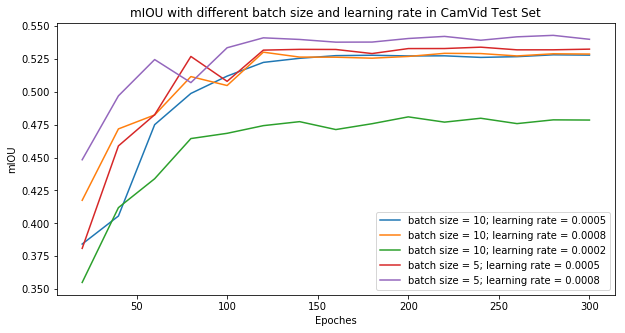

In [109]:
%matplotlib inline
import matplotlib.pyplot as plt
time_list = []
for i in range(15):
    time_list.append((i+1)*20)
    
fig = plt.figure(figsize=(10,5))
ax1 = fig.add_subplot(111)
ax1.plot(time_list,miou_batch10_list, label="batch size = 10; learning rate = 0.0005")
ax1.plot(time_list,miou_batch10_lr8_list, label="batch size = 10; learning rate = 0.0008")
ax1.plot(time_list,miou_batch10_lr2_list, label="batch size = 10; learning rate = 0.0002")
ax1.plot(time_list,miou_batch5_list, label="batch size = 5; learning rate = 0.0005")
ax1.plot(time_list,miou_batch5_lr8_list, label="batch size = 5; learning rate = 0.0008")
ax1.set_xlabel("Epoches")
ax1.set_ylabel("mIOU")
ax1.set_title("mIOU with different batch size and learning rate in CamVid Test Set")
plt.legend(loc=0)
# plt.show()
fig.savefig("CamVid_0.png")

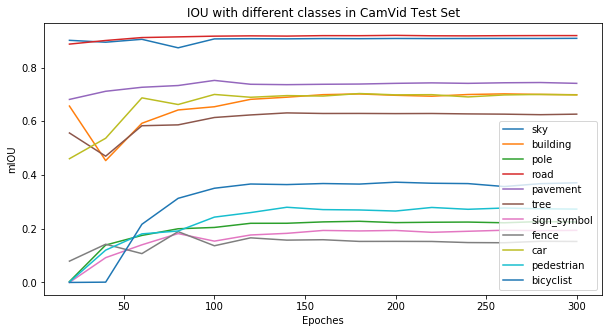

In [122]:
%matplotlib inline
import matplotlib.pyplot as plt
time_list = []
for i in range(15):
    time_list.append((i+1)*20)

import numpy as np
iou_batch10 = np.array(iou_batch10_list).T

fig = plt.figure(figsize=(10,5))
ax1 = fig.add_subplot(111)
ax1.plot(time_list,iou_batch10[0], label="sky")
ax1.plot(time_list,iou_batch10[1], label="building")
ax1.plot(time_list,iou_batch10[2], label="pole")
ax1.plot(time_list,iou_batch10[3], label="road")
ax1.plot(time_list,iou_batch10[4], label="pavement")
ax1.plot(time_list,iou_batch10[5], label="tree")
ax1.plot(time_list,iou_batch10[6], label="sign_symbol")
ax1.plot(time_list,iou_batch10[7], label="fence")
ax1.plot(time_list,iou_batch10[8], label="car")
ax1.plot(time_list,iou_batch10[9], label="pedestrian")
ax1.plot(time_list,iou_batch10[10], label="bicyclist")
ax1.set_xlabel("Epoches")
ax1.set_ylabel("mIOU")
ax1.set_title("IOU with different classes in CamVid Test Set")
plt.legend(loc=0)
# plt.show()
fig.savefig("CamVid_1.png")

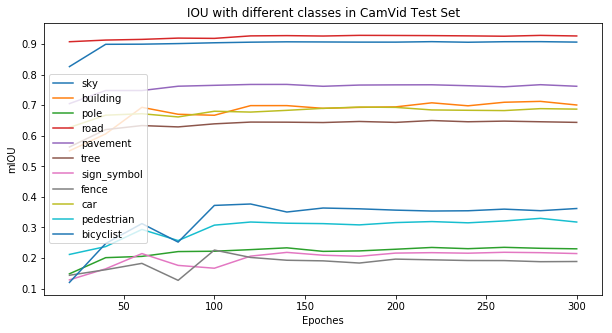

In [121]:
%matplotlib inline
import matplotlib.pyplot as plt
time_list = []
for i in range(15):
    time_list.append((i+1)*20)

import numpy as np
iou_batch10 = np.array(iou_batch5_lr8_list).T

fig = plt.figure(figsize=(10,5))
ax1 = fig.add_subplot(111)
ax1.plot(time_list,iou_batch10[0], label="sky")
ax1.plot(time_list,iou_batch10[1], label="building")
ax1.plot(time_list,iou_batch10[2], label="pole")
ax1.plot(time_list,iou_batch10[3], label="road")
ax1.plot(time_list,iou_batch10[4], label="pavement")
ax1.plot(time_list,iou_batch10[5], label="tree")
ax1.plot(time_list,iou_batch10[6], label="sign_symbol")
ax1.plot(time_list,iou_batch10[7], label="fence")
ax1.plot(time_list,iou_batch10[8], label="car")
ax1.plot(time_list,iou_batch10[9], label="pedestrian")
ax1.plot(time_list,iou_batch10[10], label="bicyclist")
ax1.set_xlabel("Epoches")
ax1.set_ylabel("mIOU")
ax1.set_title("IOU with different classes in CamVid Test Set")
plt.legend(loc=0)
# plt.show()
fig.savefig("CamVid_2.png")